In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet101
import zipfile
from PIL import Image
import albumentations as album

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)


Device: cuda


In [ ]:
# from google.colab import drive
# !rm -r /content/drive/*

# drive.mount('/content/drive')

In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
import zipfile
import os
from PIL import Image

zip_file_path = "/content/Cam101.zip"
extract_path = "/content/Cam101/Cam101"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset_path = "/content/Cam101/Cam101/Cam101"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

print(os.listdir(dataset_path))
print(os.listdir(train_path))
print(os.listdir(test_path))

train_images = []
train_labels = []
test_images = []
test_labels = []

for filename in os.listdir(train_path):
    if filename.endswith(".png"):
        image_path = os.path.join(train_path, filename)
        label_path = os.path.join(train_path, filename.replace(".png", "_L.png")).replace("_L_L", "_L")

        image = Image.open(image_path)
        label = Image.open(label_path)
        train_images.append(image)
        train_labels.append(label)

for filename in os.listdir(test_path):
    if filename.endswith(".png"):
        image_path = os.path.join(test_path, filename)
        label_path = os.path.join(test_path, filename.replace(".png", "_L.png")).replace("_L_L", "_L")

        image = Image.open(image_path)
        label = Image.open(label_path)
        test_images.append(image)
        test_labels.append(label)


['train', 'label_colors.txt', 'readme.txt', 'test']
['0016E5_08149_L.png', '0016E5_08073.png', '0016E5_08001_L.png', '0016E5_08149.png', '0016E5_08081_L.png', '0016E5_08105_L.png', '0016E5_08017.png', '0016E5_08109.png', '0016E5_07993_L.png', '0016E5_08089_L.png', '0016E5_08027_L.png', '0016E5_07971_L.png', '0016E5_08057.png', '0016E5_08129.png', '0016E5_08065.png', '0016E5_07961.png', '0016E5_08077.png', '0016E5_08153_L.png', '0016E5_08051.png', '0016E5_08011.png', '0016E5_07989.png', '0016E5_08041.png', '0016E5_07969_L.png', '0016E5_08147_L.png', '0016E5_08039.png', '0016E5_07967_L.png', '0016E5_08005.png', '0016E5_08045.png', '0016E5_08049.png', '0016E5_08111_L.png', '0016E5_08137_L.png', '0016E5_07995_L.png', '0016E5_08151.png', '0016E5_08069.png', '0016E5_08123_L.png', '0016E5_07963_L.png', '0016E5_07989_L.png', '0016E5_08003_L.png', '0016E5_07965_L.png', '0016E5_08081.png', '0016E5_08021_L.png', '0016E5_08145.png', '0016E5_08139.png', '0016E5_08045_L.png', '0016E5_08047.png', '00

In [ ]:
print("Number of training samples:", len(train_images))
print("Number of testing samples:", len(test_images))


Number of training samples: 180
Number of testing samples: 22


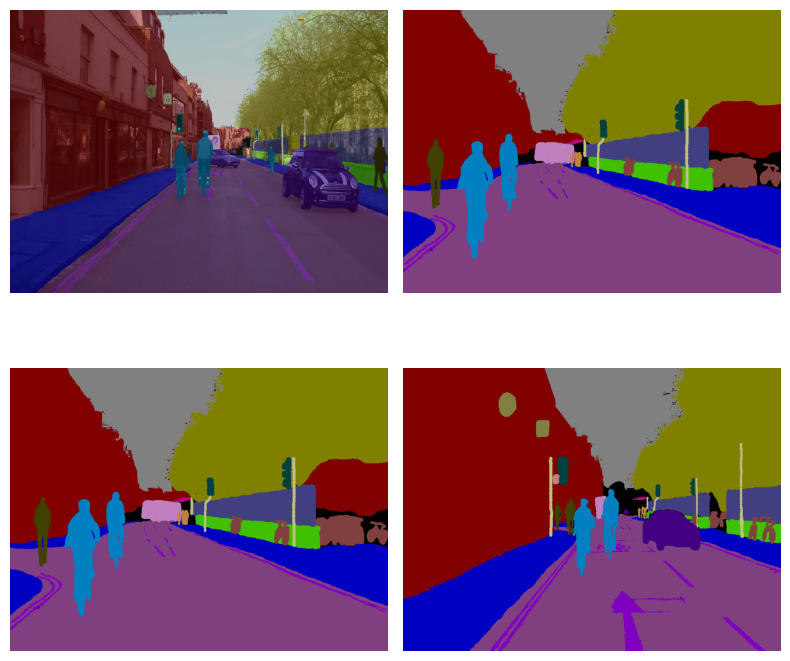

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs = axs.flatten()

for i in range(4):
    index = np.random.randint(len(train_images))
    image = train_images[index]
    label = train_labels[index]
    axs[i].imshow(image)
    axs[i].imshow(label, alpha=0.5, cmap='jet')  # Adjust the alpha and cmap for label visualization
    axs[i].set_axis_off()

plt.tight_layout() 
plt.show()


In [ ]:
import numpy as np

def decode_segmap(image, nc=32):
    label_colors = np.array([
        (64, 128, 64),   # Animal
        (192, 0, 128),   # Archway
        (0, 128, 192),   # Bicyclist
        (0, 128, 64),    # Bridge
        (128, 0, 0),     # Building
        (64, 0, 128),    # Car
        (64, 0, 192),    # CartLuggagePram
        (192, 128, 64),  # Child
        (192, 192, 128), # Column_Pole
        (64, 64, 128),   # Fence
        (128, 0, 192),   # LaneMkgsDriv
        (192, 0, 64),    # LaneMkgsNonDriv
        (128, 128, 64),  # Misc_Text
        (192, 0, 192),   # MotorcycleScooter
        (128, 64, 64),   # OtherMoving
        (64, 192, 128),  # ParkingBlock
        (64, 64, 0),     # Pedestrian
        (128, 64, 128),  # Road
        (128, 128, 192), # RoadShoulder
        (0, 0, 192),     # Sidewalk
        (192, 128, 128), # SignSymbol
        (128, 128, 128), # Sky
        (64, 128, 192),  # SUVPickupTruck
        (0, 0, 64),      # TrafficCone
        (0, 64, 64),     # TrafficLight
        (192, 64, 128),  # Train
        (128, 128, 0),   # Tree
        (192, 128, 192), # Truck_Bus
        (64, 0, 64),     # Tunnel
        (192, 192, 0),   # VegetationMisc
        (0, 0, 0),       # Void
        (64, 192, 0),    # Wall
    ])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


In [ ]:
# def rgb_to_index(label, label_colors):
#     index_label = np.zeros((label.height, label.width), dtype=np.uint8)
#     for i, color in enumerate(label_colors):
#         match = np.where(np.array(label) == color)
#         index_label[match[0], match[1]] = i
#     return Image.fromarray(index_label, mode='L')

def rgb_to_class_index(mask, mapping):
    """
    Converts an RGB mask to a class index mask using the provided mapping.

    Args:
    - mask (np.ndarray): A 3D numpy array representing an RGB mask.
    - mapping (dict): A dictionary mapping RGB tuples to class indices.

    Returns:
    - A 2D numpy array representing a class index mask.
    """
    height, width, _ = mask.shape
    class_index_mask = np.zeros((height, width), dtype=np.int64)

    for rgb, class_index in mapping.items():
        class_index_mask[(mask == rgb).all(axis=2)] = class_index

    return class_index_mask


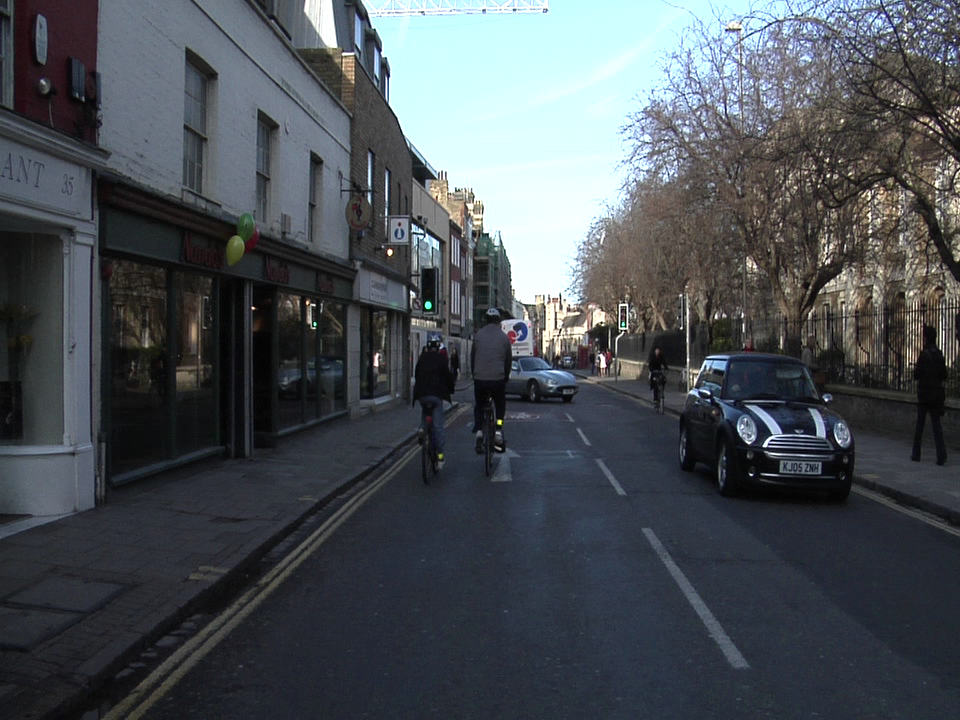

In [ ]:
from PIL import Image

# Open the image
image = Image.open(image_path)

# Convert the image to RGB mode
rgb_image = image.convert('RGB')

# Show the RGB image
rgb_image.show()


In [ ]:
from sklearn.model_selection import train_test_split
# Split the augmented training dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, label_colors, mapping, transform=None, augmentation=None, preprocessing=None):
        self.images = images
        self.labels = labels
        self.label_colors = label_colors
        self.mapping = mapping
        self.transform = transform
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
    # Read image and mask
        image = self.images[i]
        mask = self.labels[i]

    # Convert the PIL Images to NumPy arrays
        image = np.array(image)
        mask = np.array(mask)

    # Convert the mask from RGB to class index
        mask = rgb_to_class_index(mask, self.mapping)

        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask






In [ ]:
import albumentations as album

def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, is_mask=False, **kwargs):
    if is_mask:
        return x.astype('float32')
    else:
        return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=lambda x, **kwargs: to_tensor(x, is_mask=True, **kwargs)))

    return album.Compose(_transform)



In [ ]:
import random
import matplotlib.pyplot as plt

label_colors = np.array([
    (64, 128, 64),   # Animal
    (192, 0, 128),   # Archway
    (0, 128, 192),   # Bicyclist
    (0, 128, 64),    # Bridge
    (128, 0, 0),     # Building
    (64, 0, 128),    # Car
    (64, 0, 192),    # CartLuggagePram
    (192, 128, 64),  # Child
    (192, 192, 128), # Column_Pole
    (64, 64, 128),   # Fence
    (128, 0, 192),   # LaneMkgsDriv
    (192, 0, 64),    # LaneMkgsNonDriv
    (128, 128, 64),  # Misc_Text
    (192, 0, 192),   # MotorcycleScooter
    (128, 64, 64),   # OtherMoving
    (64, 192, 128),  # ParkingBlock
    (64, 64, 0),     # Pedestrian
    (128, 64, 128),  # Road
    (128, 128, 192), # RoadShoulder
    (0, 0, 192),     # Sidewalk
    (192, 128, 128), # SignSymbol
    (128, 128, 128), # Sky
    (64, 128, 192),  # SUVPickupTruck
    (0, 0, 64),      # TrafficCone
    (0, 64, 64),     # TrafficLight
    (192, 64, 128),  # Train
    (128, 128, 0),   # Tree
    (192, 128, 192), # Truck_Bus
    (64, 0, 64),     # Tunnel
    (192, 192, 0),   # VegetationMisc
    (0, 0, 0),       # Void
    (64, 192, 0),    # Wall
])
# Define the mapping from RGB tuples to class indices
mapping = {
    (64, 128, 64): 0,   # Animal
    (192, 0, 128): 1,   # Archway
    (0, 128, 192): 2,   # Bicyclist
    (0, 128, 64): 3,   # Bridge
    (128, 0, 0): 4,    # Building
    (64, 0, 128): 5,    # Car
    (64, 0, 192): 6,    # CartLuggagePram
    (192, 128, 64):7,  # Child
    (192, 192, 128):8, # Column_Pole
    (64, 64, 128):9,   # Fence
    (128, 0, 192):10,   # LaneMkgsDriv
    (192, 0, 64):11,   # LaneMkgsNonDriv
    (128, 128, 64):12,  # Misc_Text
    (192, 0, 192):13,   # MotorcycleScooter
    (128, 64, 64):14 ,  # OtherMoving
    (64, 192, 128):15 ,# ParkingBlock
    (64, 64, 0):16     ,# Pedestrian
    (128, 64, 128):17 , # Road
    (128, 128, 192):18 ,# RoadShoulder
    (0, 0, 192):19     ,# Sidewalk
    (192, 128, 128):20 ,# SignSymbol
    (128, 128, 128):21 ,# Sky
    (64, 128, 192):22  ,# SUVPickupTruck
    (0, 0, 64):23     ,# TrafficCone
    (0, 64, 64):24     ,# TrafficLight
    (192, 64, 128):25  ,# Train
    (128, 128, 0):26  , # Tree
    (192, 128, 192):27 ,# Truck_Bus
    (64, 0, 64):28  ,   # Tunnel
    (192, 192, 0):29 , # VegetationMisc
    (0, 0, 0):31      , # Void
    (64, 192, 0): 31,   # Wall
}

# Instantiate your CustomDataset, passing the mapping
dataset = CustomDataset(train_images, train_labels, label_colors, mapping, transform=None, augmentation=None, preprocessing=None)
for key, value in mapping.items():
    if value < 0 or value > 31:
        print(f"Invalid value {value} for RGB tuple {key}")




# def visualize(**images):
#     n = len(images)
#     plt.figure(figsize=(16, 5))
    
#     for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())
#         if image.ndim == 3 and image.shape[0] == 3:
#             plt.imshow(image.transpose(1, 2, 0))
#         else:
#             plt.imshow(image)
    
#     plt.show()
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.ndim == 3 and image.shape[0] == 3:
            plt.imshow((image.transpose(1, 2, 0).clip(0, 1) * 255).astype(np.uint8))
        else:
            plt.imshow(image)
    
    plt.show()



# Get a random index
random_idx = random.randint(0, len(dataset) - 1)

# Get the image and mask at the random index
image, mask = dataset[random_idx]






In [ ]:



# Instantiate the CustomDataset for training, validation, and testing
train_dataset = CustomDataset(train_images, train_labels, label_colors, mapping,
                              transform=get_training_augmentation(), preprocessing=get_preprocessing())
val_dataset = CustomDataset(val_images, val_labels, label_colors, mapping,
                            transform=get_validation_augmentation(), preprocessing=get_preprocessing())
test_dataset = CustomDataset(test_images, test_labels, label_colors, mapping,
                             transform=get_validation_augmentation(), preprocessing=get_preprocessing())

num_train_images = len(train_dataset)
print(num_train_images)
# Create data loaders for training, validation, and testing
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


162


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:2210: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [ ]:
augmented_dataset = CustomDataset(
    train_images, train_labels, label_colors,mapping,
    augmentation=get_training_augmentation(), preprocessing=get_preprocessing()
)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    random_idx = random.randint(0, len(augmented_dataset) - 1)
    image, mask = augmented_dataset[random_idx]
    
    print(f"Mask min: {np.min(mask)}, max: {np.max(mask)}")
    # Assuming 'masks' is your tensor of labels
    masks_adjusted = mask - mask.min()

    print("Adjusted mask min: ", masks_adjusted.min().item())
    print("Adjusted mask max: ", masks_adjusted.max().item())

    
    # visualize(
    #     original_image=image,
    #     ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), label_colors),
    #     one_hot_encoded_mask=reverse_one_hot(mask)
    # )



Mask min: 4.0, max: 31.0
Adjusted mask min:  0.0
Adjusted mask max:  27.0
Mask min: 2.0, max: 31.0
Adjusted mask min:  0.0
Adjusted mask max:  29.0
Mask min: 2.0, max: 31.0
Adjusted mask min:  0.0
Adjusted mask max:  29.0


In [ ]:
!pip install segmentation_models_pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=86c027c2dd61a2fba6c701e28e0767db451e06bd9c129aa6798c5d872808da17
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a6f074d5909592b1da73521047a890ea4a835402e9afd32c09ec2c781a54287f
  Stored in directory: /root/.cache/pip/w

In [ ]:

import cv2
import segmentation_models_pytorch as smp

# set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the pre-trained U-Net model
model = smp.Unet(
    encoder_name='resnet101', 
    encoder_weights='imagenet', 
    classes=32,  # Set the number of classes to 32
    activation=None,  # Do not apply activation here, because CrossEntropyLoss expects raw logits
)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 251MB/s]


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm.auto import tqdm
# import torch.nn.functional as F

# num_epochs = 1
# num_classes = 32
# model = model.to(device)

# # class PixelWiseCrossEntropyLoss(nn.Module):
# #     def __init__(self):
# #         super(PixelWiseCrossEntropyLoss, self).__init__()
# #         self.loss = nn.CrossEntropyLoss()

# #     def forward(self, input, target):
# #         return self.loss(input, target)

# # class WeightedPixelWiseCrossEntropyLoss(nn.Module):
# #     def __init__(self, weight):
# #         super(WeightedPixelWiseCrossEntropyLoss, self).__init__()
# #         self.loss = nn.CrossEntropyLoss(weight=weight)

# #     def forward(self, input, target):
# #         return self.loss(input, target)


# # class DiceLoss(nn.Module):
# #     def __init__(self):
# #         super(DiceLoss, self).__init__()

# #     def forward(self, input, target):
# #         smooth = 1.
# #         input = input.view(-1)
# #         target = target.view(-1)
# #         intersection = (input * target).sum()
# #         return 1 - ((2. * intersection + smooth) / (input.sum() + target.sum() + smooth))

# def compute_iou(pred, target, num_classes):
#     iou = 0
#     for cls in range(num_classes):
#         pred_mask = (pred == cls).float()
#         target_mask = (target == cls).float()

#         intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
#         union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
#         iou += (intersection + 1e-6) / (union + 1e-6)
#     iou /= num_classes
#     return iou

# # Lists to store the training loss and evaluation metrics
# train_loss_history = []
# val_iou_history = []

# # Define the possible hyperparameters you wish to tune
# learning_rates = [0.001, 0.01, 0.1]
# optimizers = [optim.Adam, optim.SGD]
# # loss_funcs = [ WeightedPixelWiseCrossEntropyLoss, DiceLoss]  # Add your own custom loss functions here

# # Grid search over the hyperparameters
# for learning_rate in learning_rates:
#     for optimizer_type in optimizers:
#         # for loss_func in loss_funcs:
#             # Initialize the optimizer and loss function
#             # if loss_func == WeightedPixelWiseCrossEntropyLoss:
#                 class_weights = torch.ones(num_classes).to(device)  # Now on GPU
#                 criterion = loss_func(class_weights)

#             else:
#                 criterion = loss_func()

#             optimizer = optimizer_type(model.parameters(), lr=learning_rate)
            
#             # Training and validation
#             for epoch in range(num_epochs):
#                 model.train()
#                 train_loss = 0.0

#                 for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#                     masks = masks.clip(0, num_classes - 1)
#                     images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom
#                     masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom

#                     images = images.to(device)
#                     masks_adjusted = masks
#                     masks_adjusted = masks_adjusted.to(device)

#                     # Forward pass
#                     masks_adjusted = masks_adjusted.long()  # Convert masks to Long type
#                     outputs = model(images)
#                     outputs = outputs.squeeze(1)

#                     loss = criterion(outputs, masks_adjusted)

#                     # Backward pass and optimization
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                     train_loss += loss.item()

#                 # Calculate average training loss
#                 train_loss /= len(train_dataloader)
#                 train_loss_history.append(train_loss)

#                 # Validation
#                 model.eval()
#                 val_iou = 0.0
#                 with torch.no_grad():
#                     for images, masks in val_dataloader:
#                         masks = masks.clip(0, num_classes - 1)
                        
#                         # Pad images to make dimensions divisible by 32
#                         h, w = images.shape[-2:]
#                         new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
#                         new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
#                         images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
#                         masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)

#                         images = images.to(device)
#                         masks_adjusted = masks_adjusted.to(device)

#                         # Forward pass
#                         outputs = model(images)
#                         pred = torch.softmax(outputs, dim=1)  # Apply softmax to get probability distributions
#                         pred = torch.argmax(pred, dim=1)

#                         # Compute evaluation metrics
#                         val_iou += compute_iou(pred, masks_adjusted, num_classes)

#                     # Calculate average evaluation metrics
#                     val_iou /= len(val_dataloader)
#                     val_iou_history.append(val_iou)

#                 # Print epoch results
#                 print(f"Epoch [{epoch+1}/{num_epochs}], "
#                       f"Learning rate: {learning_rate}, Optimizer: {optimizer_type.__name__}, Loss function: {loss_func.__name__}, "
#                       f"Train Loss: {train_loss:.4f}, Val IoU: {val_iou.mean().item():.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn.functional as F

num_epochs = 1
num_classes = 32
model = model.to(device)

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

train_loss_history = []
val_iou_history = []

learning_rates = [0.001, 0.01, 0.1]
optimizers = [optim.Adam, optim.SGD]

criterion = nn.CrossEntropyLoss()

for learning_rate in learning_rates:
    for optimizer_type in optimizers:
        optimizer = optimizer_type(model.parameters(), lr=learning_rate)
            
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                masks = masks.clip(0, num_classes - 1)
                images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0) 
                masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0) 

                images = images.to(device)
                masks_adjusted = masks_adjusted.to(device)

                masks_adjusted = masks_adjusted.long()  
                outputs = model(images)

                # Resize output to match target's size
                outputs = F.interpolate(outputs, size=masks_adjusted.shape[1:], mode='bilinear', align_corners=False)

                loss = criterion(outputs, masks_adjusted)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_dataloader)
            train_loss_history.append(train_loss)

            model.eval()
            val_iou = 0.0
            with torch.no_grad():
                for images, masks in val_dataloader:
                    masks = masks.clip(0, num_classes - 1)
                    
                    h, w = images.shape[-2:]
                    new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
                    new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
                    images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                    masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                    images = images.to(device)
                    masks_adjusted = masks_adjusted.to(device)

                    # Forward pass
                    outputs = model(images)
                    pred = torch.softmax(outputs, dim=1)  # Apply softmax to get probability distributions
                    pred = torch.argmax(pred, dim=1)

                    # Compute evaluation metrics
                    val_iou += compute_iou(pred, masks_adjusted, num_classes)

                # Calculate average evaluation metrics
                val_iou /= len(val_dataloader)
                val_iou_history.append(val_iou)

            # Print epoch results
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Learning rate: {learning_rate}, Optimizer: {optimizer_type.__name__}, "
                  f"Train Loss: {train_loss:.4f}, Val IoU: {val_iou.mean().item():.4f}")

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Optimizer: Adam, Train Loss: 1.1392, Val IoU: 0.5380


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Optimizer: SGD, Train Loss: 0.6061, Val IoU: 0.5453


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Optimizer: Adam, Train Loss: 0.9779, Val IoU: 0.4938


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Optimizer: SGD, Train Loss: 0.6772, Val IoU: 0.5370


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Optimizer: Adam, Train Loss: 1.7049, Val IoU: 0.4215


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Optimizer: SGD, Train Loss: 1.1519, Val IoU: 0.4440


Best one with Adam and lr=0.001

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Train Loss: 1.0942, Val IoU: 0.4590


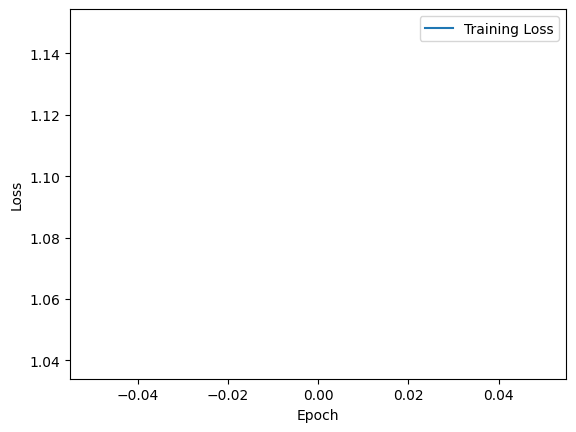

In [ ]:
import os

os.environ['TORCH_USE_CUDA_DSA'] = '1'

# rest of your code goes here

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn.functional as F



# Define hyperparameters
learning_rate = 0.001
num_epochs = 1
num_classes = 32
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

# Lists to store the training loss and evaluation metrics
train_loss_history = []
val_iou_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training iteration
    # Training iteration
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
      masks = masks.clip(0, num_classes - 1)
    
    # Pad images and masks to make their dimensions divisible by 32
      images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom
      masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom

      images = images.to(device)  # Move the images to the device
      masks_adjusted = masks_adjusted.to(device)

    # Forward pass
      masks_adjusted = masks_adjusted.long()  # Convert masks to Long type

      outputs = model(images)
      outputs = outputs.squeeze(1)
    
      loss = criterion(outputs, masks_adjusted)


        # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # print(f"Batch Loss: {loss.item()}")

      # # Compute IoU for the batch and print
      # pred = torch.argmax(outputs, dim=1)
      # iou = compute_iou(pred, masks_adjusted, num_classes)
      # print(f"Batch IoU: {iou.mean().item()}")

      train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)



# Validation
model.eval()
val_iou = 0.0
with torch.no_grad():
    for images, masks in val_dataloader:
        masks = masks.clip(0, num_classes - 1)
        
        # Pad images to make dimensions divisible by 32
        h, w = images.shape[-2:]
        new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
        new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
        images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
        masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)

        images = images.to(device)
        masks_adjusted = masks_adjusted.to(device)

        # Forward pass
        outputs = model(images)
        pred = torch.softmax(outputs, dim=1)  # Apply softmax to get probability distributions
        pred = torch.argmax(pred, dim=1)

        # Compute evaluation metrics
        val_iou += compute_iou(pred, masks_adjusted, num_classes)

    # Calculate average evaluation metrics
    val_iou /= len(val_dataloader)
    val_iou_history.append(val_iou)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, "
      f"Val IoU: {val_iou.mean().item():.4f}")





# Plot loss function history
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [1.0393625814237712]
Validation Mean IoU: 0.4591417610645294


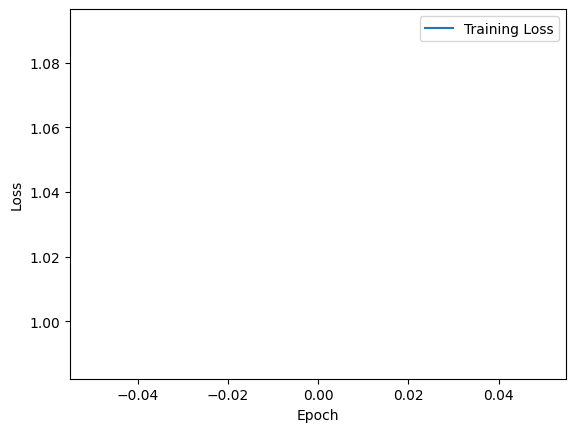

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [1.6406591483104376]
Validation Mean IoU: 0.45692968368530273


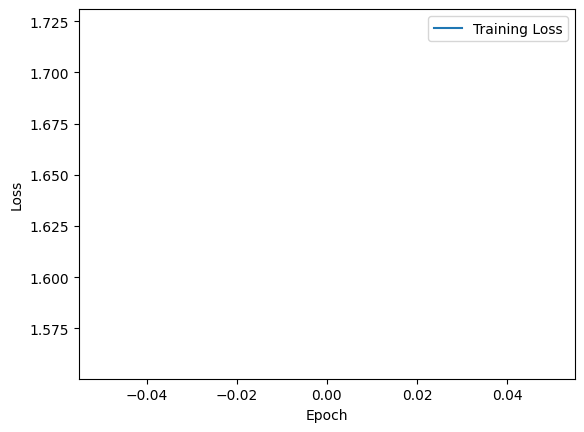

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for DiceLoss:
Training loss: [0.8873302266921526]
Validation Mean IoU: 0.487525999546051


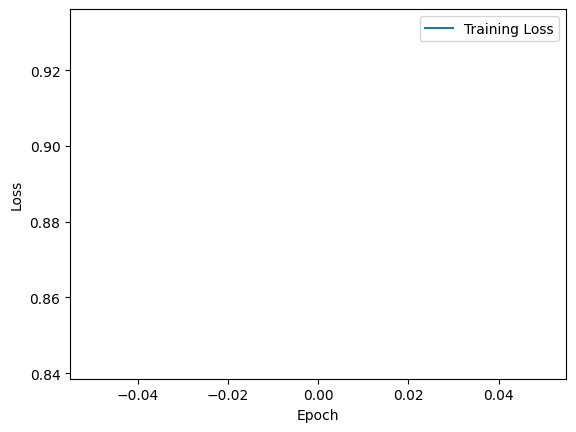

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn.functional as F


model = model.to(device)
num_epochs=1
learning_rate= 0.001
num_classes=32
# Create a list to hold the counts of each class
class_counts = [0] * num_classes

# Loop over your dataset
for images, masks in train_dataloader:
    for cls in range(num_classes):
        class_counts[cls] += (masks == cls).sum().item()

# Normalize the counts to get a probability distribution
total_count = sum(class_counts)
class_probs = [count / total_count for count in class_counts]


# The weight for each class is the inverse of its probability
class_weights = [1 / (prob + 1e-6) for prob in class_probs]  # Add a small constant to avoid division by zero



# Define the weighted cross entropy loss
class_weights = torch.tensor([class_weights], device=device) # Replace class_weights with a list containing the weights for each class
WeightedCrossEntropyLoss = nn.CrossEntropyLoss(weight=class_weights)

# Define the dice loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = 2.0 * (intersection + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

DiceLoss = DiceLoss()
def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

# Lists to store the training loss and evaluation metrics
train_loss_history = []
val_iou_history = []
# Create a list of the loss functions
loss_functions = [nn.CrossEntropyLoss(), WeightedCrossEntropyLoss, DiceLoss]

# Loop through the list of loss functions
for loss_func in loss_functions:
    criterion = loss_func

    # Reset the model and optimizer
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store the training loss and evaluation metrics
    train_loss_history = []
    val_iou_history = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        # Training iteration
        for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            masks = masks.clip(0, num_classes - 1)

            # Pad images and masks to make their dimensions divisible by 32
            images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom
            masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom

            images = images.to(device)  # Move the images to the device
            masks_adjusted = masks_adjusted.to(device)

            # Forward pass
            masks_adjusted = masks_adjusted.long()  # Convert masks to Long type

            outputs = model(images)
            outputs = outputs.squeeze(1)

            loss = criterion(outputs, masks_adjusted)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate average training loss
        train_loss /= len(train_dataloader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in val_dataloader:
                masks = masks.clip(0, num_classes - 1)

                # Pad images to make dimensions divisible by 32
                h, w = images.shape[-2:]
                new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
                new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
                images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)

                images = images.to(device)
                masks_adjusted = masks_adjusted.to(device)

                # Forward pass
                outputs = model(images)
                pred = torch.softmax(outputs, dim=1)  # Apply softmax to get probability distributions
                pred = torch.argmax(pred, dim=1)

                # Compute evaluation metrics
                val_iou += compute_iou(pred, masks_adjusted, num_classes)

            # Calculate average evaluation metrics
            val_iou /= len(val_dataloader)
            val_iou_history.append(val_iou)

    # Print the performance metrics for the current loss function
    print(f"Performance metrics for {criterion.__class__.__name__}:")
    print(f"Training loss: {train_loss_history}")
    print(f"Validation Mean IoU: {val_iou.mean().item()}")


    # Plot loss function history
    plt.plot(train_loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs=1
learning_rate= 0.001
num_classes=32
num_folds = 5

class_counts = [0] * num_classes
for images, masks in train_dataloader:
    for cls in range(num_classes):
        class_counts[cls] += (masks == cls).sum().item()
total_count = sum(class_counts)
class_probs = [count / total_count for count in class_counts]
class_weights = [1 / (prob + 1e-6) for prob in class_probs] 
class_weights = torch.tensor([class_weights], device=device) 

WeightedCrossEntropyLoss = nn.CrossEntropyLoss(weight=class_weights)

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = 2.0 * (intersection + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

DiceLoss = DiceLoss()

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()
        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

dataset = list(zip(train_images, train_labels))  # Assuming train_images and train_labels are your complete dataset

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

loss_functions = [nn.CrossEntropyLoss(), WeightedCrossEntropyLoss, DiceLoss]

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"FOLD {fold+1}/{num_folds}")

    train_images_fold = [dataset[i][0] for i in train_ids]
    train_labels_fold = [dataset[i][1] for i in train_ids]
    val_images_fold = [dataset[i][0] for i in val_ids]
    val_labels_fold = [dataset[i][1] for i in val_ids]

    # create your dataloaders here

    for loss_func in loss_functions:
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = loss_func

        train_loss_history = []
        val_iou_history = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                masks = masks.clip(0, num_classes - 1)

                images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0)
                masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0)

                images = images.to(device)
                masks_adjusted = masks_adjusted.to(device)
                masks_adjusted = masks_adjusted.long()

                outputs = model(images)
                outputs = outputs.squeeze(1)

                loss = criterion(outputs, masks_adjusted)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_dataloader)
            train_loss_history.append(train_loss)

            model.eval()
            val_iou = 0.0
            with torch.no_grad():
                for images, masks in val_dataloader:
                    masks = masks.clip(0, num_classes - 1)

                    h, w = images.shape[-2:]
                    new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
                    new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
                    images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                    masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)

                    images = images.to(device)
                    masks_adjusted = masks_adjusted.to(device)

                    outputs = model(images)
                    pred = torch.softmax(outputs, dim=1)
                    pred = torch.argmax(pred, dim=1)

                    val_iou += compute_iou(pred, masks_adjusted, num_classes)

                val_iou /= len(val_dataloader)
                val_iou_history.append(val_iou)

        print(f"Performance metrics for {criterion.__class__.__name__}:")
        print(f"Training loss: {train_loss_history}")
        print(f"Validation Mean IoU: {val_iou.mean().item()}")

        plt.plot(train_loss_history, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()



final model u_net with test
with SGD,learning rate 

Epoch 1/1: 100%|██████████| 81/81 [02:42<00:00,  2.01s/it]


Epoch [1/1], Train Loss: 0.8768, Train IoU: 39.8481, Train Pixel Accuracy: 0.7376, Test IoU: 0.4814, Test Pixel Accuracy: 0.7462


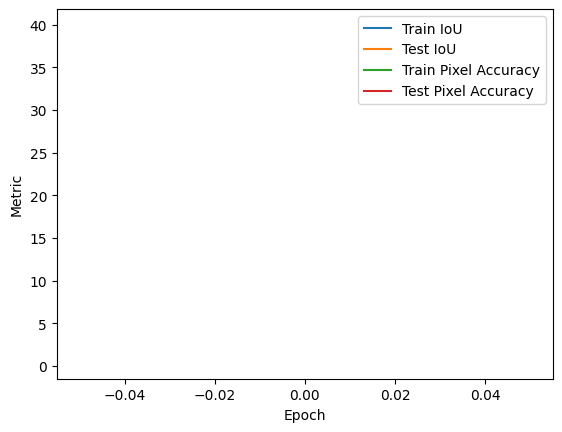

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Padding function to ensure image dimensions are divisible by 32
def pad_image(image, target_size):
    h, w = image.shape[-2:]
    new_h = (h // target_size + 1) * target_size if h % target_size != 0 else h
    new_w = (w // target_size + 1) * target_size if w % target_size != 0 else w
    pad_h = new_h - h
    pad_w = new_w - w
    image = F.pad(image, (0, pad_w, 0, pad_h))
    return image

num_epochs = 1

# Define the dice loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = 2.0 * (intersection + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

dice_loss = DiceLoss()

# Define the loss function
criterion = dice_loss

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store the training loss, test loss, and evaluation metrics
train_loss_history = []
test_loss_history = []
train_iou_history = []
test_iou_history = []
train_pixel_accuracy_history = []
test_pixel_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_pixel_accuracy = 0.0

    # Training iteration
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        # Padding images
        images = pad_image(images, 32)
        masks = pad_image(masks, 32)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)  # Access 'out' from the OrderedDict

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute evaluation metrics
        pred = torch.argmax(outputs, dim=1)
        train_iou += compute_iou(pred, masks, num_classes)
        train_pixel_accuracy += (pred == masks).float().mean()

    # Calculate average training loss and evaluation metrics
    train_loss /= len(train_dataloader)
    train_iou = train_iou.mean()  # Compute mean of train_iou tensor
    train_pixel_accuracy /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou.item())
    train_pixel_accuracy_history.append(train_pixel_accuracy.item())


# Testing
model.eval()

test_iou = 0.0
test_pixel_accuracy = 0.0

with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        # Padding images
        images = pad_image(images, 32)
        masks = pad_image(masks, 32)

        # Forward pass
        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)  # Access 'out' from the OrderedDict

        # Compute evaluation metrics
        test_iou += compute_iou(pred, masks, num_classes)
        test_pixel_accuracy += (pred == masks).float().mean()

    # Calculate average evaluation metrics
    test_iou /= len(test_dataloader)
    test_pixel_accuracy /= len(test_dataloader)
    test_iou_history.append(test_iou.mean().item())  # Calculate mean of test_iou tensor
    test_pixel_accuracy_history.append(test_pixel_accuracy.item())

# Print epoch results
print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, "
      f"Train IoU: {train_iou:.4f}, "
      f"Train Pixel Accuracy: {train_pixel_accuracy:.4f}, "
      f"Test IoU: {test_iou.mean():.4f}, "  # Calculate mean of test_iou tensor
      f"Test Pixel Accuracy: {test_pixel_accuracy:.4f}")

# Plot evaluation metrics history
plt.plot(train_iou_history, label='Train IoU')
plt.plot(test_iou_history, label='Test IoU')
plt.plot(train_pixel_accuracy_history, label='Train Pixel Accuracy')
plt.plot(test_pixel_accuracy_history, label='Test Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()



DEEPLABV3

In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101

# Load the pre-trained model
model = deeplabv3_resnet101(pretrained=True)

# Modify the model for your specific task
num_classes = 32
model.classifier[-1] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# Optional: Freeze the pre-trained weights
for param in model.backbone.parameters():
    param.requires_grad = False

# Print the modified model architecture
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 204MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

The Base Model

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Train Loss: 0.2297, Val IoU: 0.7113


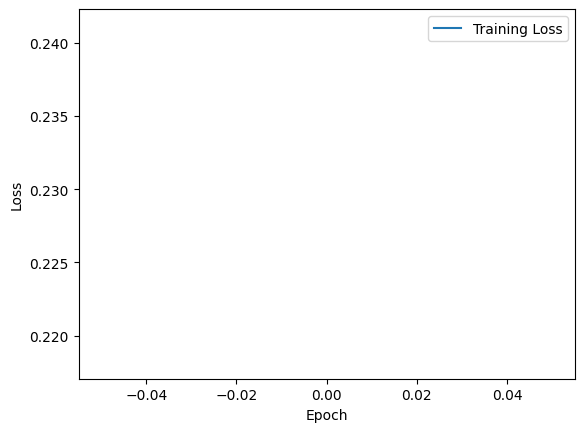

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Define hyperparameters
learning_rate = 0.001
num_epochs = 1
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# def compute_iou(pred, target, num_classes):
#     iou = 0
#     for cls in range(num_classes):
#         pred_mask = (pred.argmax(dim=1) == cls).float()
#         target_mask = (target == cls).float().squeeze(dim=1)  # Remove the extra dimension
#         print(pred_mask.size())  # print the dimensions of pred_mask
#         print(target_mask.size())  # print the dimensions of target_mask
#         intersection = (pred_mask * target_mask).sum()
#         union = (pred_mask + target_mask).sum()
#         iou += intersection / (union + 1e-10)  # Add a small epsilon to avoid division by zero
#     return iou / num_classes

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou







# Lists to store the training loss and evaluation metrics
train_loss_history = []
val_iou_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training iteration
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):

       # masks = torch.from_numpy(np.array([(one_hot_encode(m, label_colors)) for m in masks]))

        images = images.to(device)  # Move the images to the device
        masks = masks.to(device)  # This line is already in your code

        # Forward pass
        masks = masks.long()

        outputs = model(images)
        loss = criterion(outputs['out'], masks.long())

       
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
        
            # Forward pass
            outputs = model(images)
            pred = torch.argmax(outputs['out'], dim=1)

            # Compute evaluation metrics
            val_iou += compute_iou(pred, labels, num_classes)

        # Calculate average evaluation metrics
        val_iou /= len(val_dataloader)
        val_iou_history.append(val_iou)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, "
      f"Val IoU: {val_iou.mean().item():.4f}")


# Plot loss function history
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Finding the Best LR/Optimizer

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Optimizer: Adam, Train Loss: 0.1794, Val IoU: 0.7686


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Optimizer: SGD, Train Loss: 0.1316, Val IoU: 0.7661


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Optimizer: Adam, Train Loss: 0.3329, Val IoU: 0.7103


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Optimizer: SGD, Train Loss: 0.1775, Val IoU: 0.7170


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Optimizer: Adam, Train Loss: 0.7406, Val IoU: 0.6501


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Optimizer: SGD, Train Loss: 0.2407, Val IoU: 0.6555


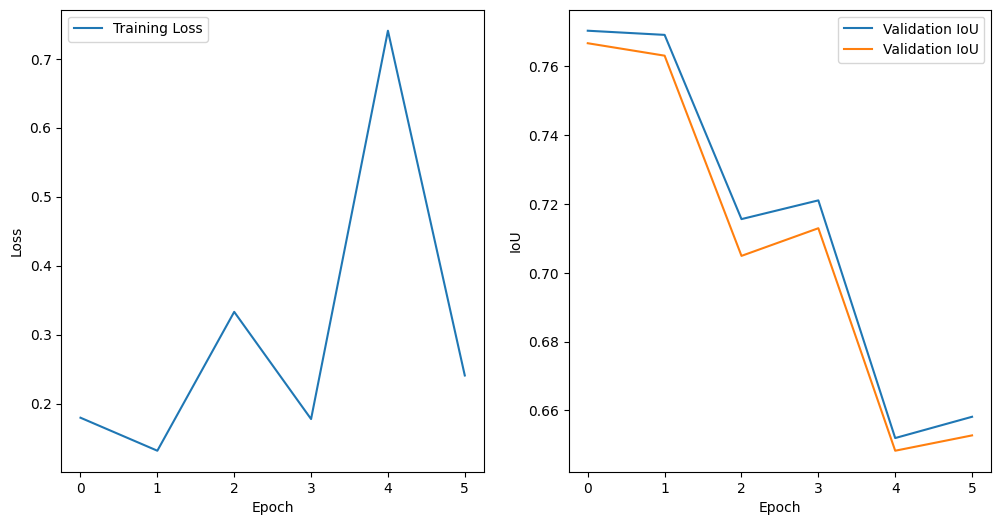

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import torch.nn.functional as F

num_epochs = 1
num_classes = 32
model = model.to(device)

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

train_loss_history = []
val_iou_history = []

learning_rates = [0.001, 0.01, 0.1]
optimizers = [optim.Adam, optim.SGD]

criterion = nn.CrossEntropyLoss()

for learning_rate in learning_rates:
    for optimizer_type in optimizers:
        optimizer = optimizer_type(model.parameters(), lr=learning_rate)
            
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                masks = masks.clip(0, num_classes - 1)
                images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0) 
                masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0) 

                images = images.to(device)
                masks_adjusted = masks_adjusted.to(device)

                masks_adjusted = masks_adjusted.long()  
                outputs = model(images)['out']

                # Resize output to match target's size
                outputs = F.interpolate(outputs, size=masks_adjusted.shape[1:], mode='bilinear', align_corners=False)

                loss = criterion(outputs, masks_adjusted)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_dataloader)
            train_loss_history.append(train_loss)

            model.eval()
            val_iou = 0.0
            with torch.no_grad():
                for images, masks in val_dataloader:
                    masks = masks.clip(0, num_classes - 1)
                    
                    h, w = images.shape[-2:]
                    new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
                    new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
                    images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                    masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                    images = images.to(device)
                    masks_adjusted = masks_adjusted.to(device)

                    # Forward pass
                    outputs = model(images)['out']
                    pred = torch.argmax(outputs, dim=1)

                    # Compute evaluation metrics
                    # Compute evaluation metrics
                    val_iou += compute_iou(pred, masks_adjusted, num_classes)

                # Calculate average evaluation metrics
                val_iou /= len(val_dataloader)
                val_iou_history.append(val_iou.cpu().numpy())


            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Learning rate: {learning_rate}, Optimizer: {optimizer_type.__name__}, "
                  f"Train Loss: {train_loss:.4f}, Val IoU: {val_iou.cpu().mean().item():.4f}")


# Plot loss function history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot IoU history
plt.subplot(1, 2, 2)
plt.plot(val_iou_history, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()


Finding the Best Loss Function

FOLD 1/5


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.2288150007342115]
Validation Mean IoU: 0.6596277952194214


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [1.0973829008914806]
Validation Mean IoU: 0.6428536176681519


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for DiceLoss:
Training loss: [0.18249446153640747]
Validation Mean IoU: 0.6756300330162048
FOLD 2/5


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.21200102512483243]
Validation Mean IoU: 0.6885554790496826


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.8627748746930817]
Validation Mean IoU: 0.6175771355628967


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for DiceLoss:
Training loss: [0.04584555493460761]
Validation Mean IoU: 0.6820254325866699
FOLD 3/5


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.20439710606027534]
Validation Mean IoU: 0.7020432949066162


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.714135033480915]
Validation Mean IoU: 0.6423805356025696


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for DiceLoss:
Training loss: [0.025397990220858726]
Validation Mean IoU: 0.7015154957771301
FOLD 4/5


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.19610431808748363]
Validation Mean IoU: 0.6958625316619873


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.619025355135953]
Validation Mean IoU: 0.6431692242622375


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for DiceLoss:
Training loss: [0.010536954726701901]
Validation Mean IoU: 0.7097361087799072
FOLD 5/5


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.1911308112335794]
Validation Mean IoU: 0.710469126701355


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for CrossEntropyLoss:
Training loss: [0.5443962282604642]
Validation Mean IoU: 0.6531933546066284


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Performance metrics for DiceLoss:
Training loss: [2.872943878173828e-05]
Validation Mean IoU: 0.7227779030799866
The best loss function was DiceLoss with a loss of -0.003578444321950277


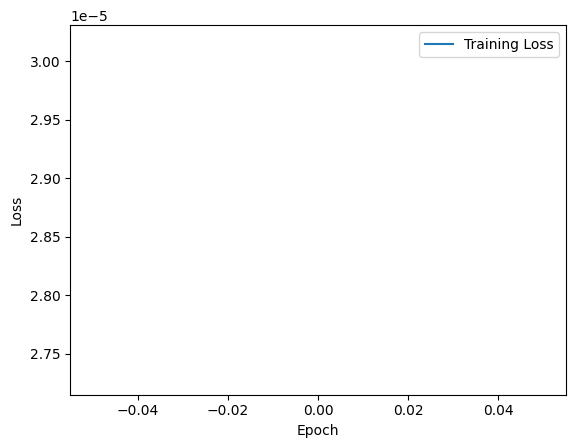

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set Hyperparameters
num_epochs= 1
learning_rate= 0.001
num_classes=32
num_folds = 5  # Number of folds for cross-validation


# Class weights for WeightedCrossEntropyLoss
class_counts = [0] * num_classes
for images, masks in train_dataloader:
    for cls in range(num_classes):
        class_counts[cls] += (masks == cls).sum().item()
total_count = sum(class_counts)
class_probs = [count / total_count for count in class_counts]
class_weights = [1 / (prob + 1e-6) for prob in class_probs] 
class_weights = torch.tensor([class_weights], device=device) 

# Define the weighted cross entropy loss
WeightedCrossEntropyLoss = nn.CrossEntropyLoss(weight=class_weights)

# Define the dice loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = 2.0 * (intersection + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

DiceLoss = DiceLoss()

# List of loss functions
loss_functions = [nn.CrossEntropyLoss(), WeightedCrossEntropyLoss, DiceLoss]
# IOU Calculation
def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()
        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

# Convert your dataset to a list if it's not already - this is required for indexing during the cross-validation loop
dataset = list(zip(train_images, train_labels))  # Assuming train_images and train_labels are your complete dataset

# Create the KFold object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

# Cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"FOLD {fold+1}/{num_folds}")

    # Select subsets of data for this fold
    train_images_fold = [dataset[i][0] for i in train_ids]
    train_labels_fold = [dataset[i][1] for i in train_ids]
    val_images_fold = [dataset[i][0] for i in val_ids]
    val_labels_fold = [dataset[i][1] for i in val_ids]

# Initialize best loss to a high value
    best_loss = float('inf')
    best_loss_func = None
    val_loss =0.0
    # Loop through the list of loss functions
    for loss_func in loss_functions:
        # Reset the model and optimizer for the current fold
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = loss_func

        # Training loop
        train_loss_history = []
        val_iou_history = []
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            # Training iteration
            for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device)
                masks = masks.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs['out'], masks.long())

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Calculate average training loss
            train_loss /= len(train_dataloader)
            train_loss_history.append(train_loss)

            # Validation
            model.eval()
            val_iou = 0.0
            val_loss = 0.0  # Reset validation loss for this epoch
            with torch.no_grad():
                for images, masks in val_dataloader:
                    images = images.to(device)
                    masks = masks.to(device)

                    # Forward pass
                    outputs = model(images)
                    pred = torch.argmax(outputs['out'], dim=1)

                    # Compute evaluation metrics
                    val_iou += compute_iou(pred, masks, num_classes)
                    # Compute validation loss
                    loss = criterion(outputs['out'], masks.long())
                    val_loss += loss.item()  # Add the loss for this batch
                # Calculate average evaluation metrics
                val_iou /= len(val_dataloader)
                val_iou_history.append(val_iou)

                # Calculate average validation loss
                val_loss /= len(val_dataloader)
                
                # Check if this loss is the best
                if val_loss < best_loss:
                  best_loss = val_loss
                  best_loss_func = loss_func

            # Print the performance metrics for the current loss function
            print(f"Performance metrics for {criterion.__class__.__name__}:")
            print(f"Training loss: {train_loss_history}")
            print(f"Validation Mean IoU: {val_iou.mean().item()}")

# After all folds and loss functions, print the best loss function
print(f"The best loss function was {best_loss_func.__class__.__name__} with a loss of {best_loss}")
 # Plot loss function history
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
                   


FINAL DEEPLABV3 WITH TEST

Epoch 1/1: 100%|██████████| 81/81 [03:17<00:00,  2.44s/it]


Epoch [1/1], Train Loss: -0.0208, Train IoU: 56.4805, Train Pixel Accuracy: 0.9177, Test IoU: 0.6991, Test Pixel Accuracy: 0.9163


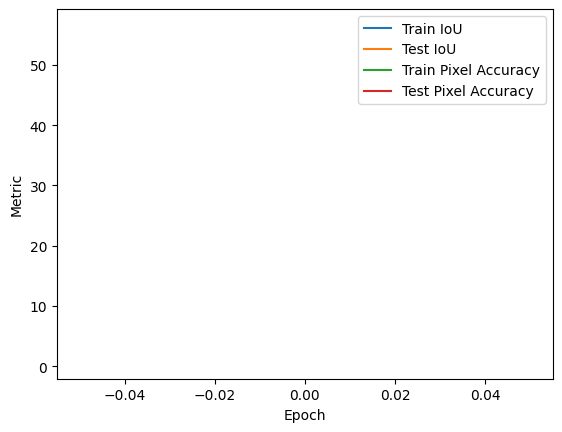

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Padding function to ensure image dimensions are divisible by 32
def pad_image(image, target_size):
    h, w = image.shape[-2:]
    new_h = (h // target_size + 1) * target_size if h % target_size != 0 else h
    new_w = (w // target_size + 1) * target_size if w % target_size != 0 else w
    pad_h = new_h - h
    pad_w = new_w - w
    image = F.pad(image, (0, pad_w, 0, pad_h))
    return image

num_epochs = 1

# Define the dice loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = 2.0 * (intersection + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

dice_loss = DiceLoss()

# Define the loss function
criterion = dice_loss

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store the training loss, test loss, and evaluation metrics
train_loss_history = []
test_loss_history = []
train_iou_history = []
test_iou_history = []
train_pixel_accuracy_history = []
test_pixel_accuracy_history = []

## Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_pixel_accuracy = 0.0

    # Training iteration
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        # Padding images
        images = pad_image(images, 32)
        masks = pad_image(masks, 32)

        # Forward pass
        outputs = model(images)
        output_main = outputs['out']  # Access the main output tensor from the OrderedDict
        loss = criterion(output_main, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute evaluation metrics
        pred = torch.argmax(output_main, dim=1)
        train_iou += compute_iou(pred, masks, num_classes)
        train_pixel_accuracy += (pred == masks).float().mean()

    # Calculate average training loss and evaluation metrics
    train_loss /= len(train_dataloader)
    train_iou = train_iou.mean()  # Compute mean of train_iou tensor
    train_pixel_accuracy /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou.item())
    train_pixel_accuracy_history.append(train_pixel_accuracy.item())


# Testing
model.eval()

test_iou = 0.0
test_pixel_accuracy = 0.0

with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        # Padding images
        images = pad_image(images, 32)
        masks = pad_image(masks, 32)

        # Forward pass
        outputs = model(images)
        pred = torch.argmax(outputs['out'], dim=1)  # Access 'out' from the OrderedDict

        # Compute evaluation metrics
        test_iou += compute_iou(pred, masks, num_classes)
        test_pixel_accuracy += (pred == masks).float().mean()

    # Calculate average evaluation metrics
    test_iou /= len(test_dataloader)
    test_pixel_accuracy /= len(test_dataloader)
    test_iou_history.append(test_iou.mean().item())  # Calculate mean of test_iou tensor
    test_pixel_accuracy_history.append(test_pixel_accuracy.item())

# Print epoch results
print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, "
      f"Train IoU: {train_iou:.4f}, "
      f"Train Pixel Accuracy: {train_pixel_accuracy:.4f}, "
      f"Test IoU: {test_iou.mean():.4f}, "  # Calculate mean of test_iou tensor
      f"Test Pixel Accuracy: {test_pixel_accuracy:.4f}")

# Plot evaluation metrics history
plt.plot(train_iou_history, label='Train IoU')
plt.plot(test_iou_history, label='Test IoU')
plt.plot(train_pixel_accuracy_history, label='Train Pixel Accuracy')
plt.plot(test_pixel_accuracy_history, label='Test Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()



FCN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp


from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights
# from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet101_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)
fcn = fcn_resnet101(weights=weights, progress=False)
fcn.eval()


# Define the pre-training function
def pretrain_fcn(model_name, num_classes, learning_rate, num_epochs, train_loader):
    # Create the FCN model
    model = smp.FPN(
        encoder_name=model_name,
        encoder_weights='imagenet',
        classes=num_classes,
        activation='softmax2d'
    )

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Set the model to training mode
    model.train()

    # Train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

    # Save the pre-trained weights
    torch.save(model.state_dict(), 'fcn_pretrained.pth')

    print('Pre-training completed.')




BASE MODEL FCN

Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Train Loss: 3.0021, Val IoU: 0.4192
Total runtime: 171.85317826271057 seconds


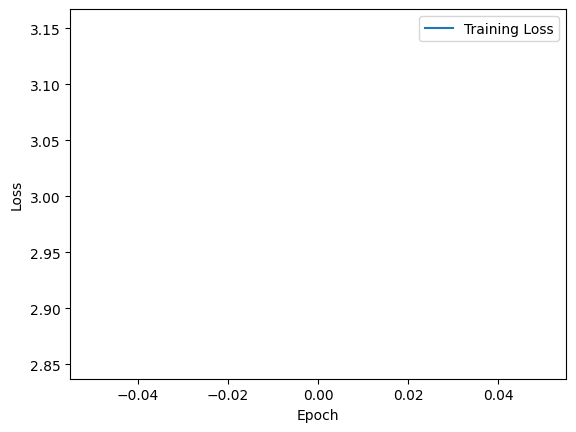

In [ ]:
import os
import time

os.environ['TORCH_USE_CUDA_DSA'] = '1'

start_time = time.time()  # start the timer

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn.functional as F



# Define hyperparameters
learning_rate = 0.01
num_epochs = 1
num_classes = 32
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

# Lists to store the training loss and evaluation metrics
train_loss_history = []
val_iou_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    
    # Training iteration
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
      masks = masks.clip(0, num_classes - 1)
    
    # Pad images and masks to make their dimensions divisible by 32
      images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom
      masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0)  # Pad bottom

      images = images.to(device)  # Move the images to the device
      masks_adjusted = masks_adjusted.to(device)

    # Forward pass
      masks_adjusted = masks_adjusted.long()  # Convert masks to Long type

      outputs = model(images)
      outputs = outputs.squeeze(1)
    
      loss = criterion(outputs, masks_adjusted)

        # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # print(f"Batch Loss: {loss.item()}")

      # # Compute IoU for the batch and print
      # pred = torch.argmax(outputs, dim=1)
      # iou = compute_iou(pred, masks_adjusted, num_classes)
      # print(f"Batch IoU: {iou.mean().item()}")

      train_loss += loss.item()

    # Calculate average training loss
    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)



# Validation
model.eval()
val_iou = 0.0
with torch.no_grad():
    for images, masks in val_dataloader:
        masks = masks.clip(0, num_classes - 1)
        
        # Pad images to make dimensions divisible by 32
        h, w = images.shape[-2:]
        new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
        new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
        images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
        masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)

        images = images.to(device)
        masks_adjusted = masks_adjusted.to(device)

        # Forward pass
        outputs = model(images)
        pred = torch.softmax(outputs, dim=1)  # Apply softmax to get probability distributions
        pred = torch.argmax(pred, dim=1)

        # Compute evaluation metrics
        val_iou += compute_iou(pred, masks_adjusted, num_classes)

    # Calculate average evaluation metrics
    val_iou /= len(val_dataloader)
    val_iou_history.append(val_iou)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, "
      f"Val IoU: {val_iou.mean().item():.4f}")



# end time
end_time = time.time()

# calculate the total runtime
runtime = end_time - start_time

print("Total runtime:", runtime, "seconds")

# Plot loss function history
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
class WeightedPixelCrossEntropy(nn.Module):
    def __init__(self, weight=None):
        super(WeightedPixelCrossEntropy, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        log_softmax_inputs = F.log_softmax(inputs, dim=1)

        if self.weight is not None:
            log_softmax_inputs = log_softmax_inputs * self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3)

        loss = -torch.sum(targets * log_softmax_inputs, dim=1)

        return loss.mean()


In [ ]:
def DiceCoefficient(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice


In [ ]:
import torch.optim as optim
import segmentation_models_pytorch as smp
import torch.nn as nn

def compute_iou(pred, target, num_classes):
    iou = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()

        intersection = (pred_mask * target_mask).sum(dim=-1).sum(dim=-1)
        union = (pred_mask + target_mask).sum(dim=-1).sum(dim=-1) - intersection
        iou += (intersection + 1e-6) / (union + 1e-6)
    iou /= num_classes
    return iou

# Lists to store the training loss and evaluation metrics
train_loss_history = []
val_iou_history = []


smp.losses.DiceLoss(mode='multiclass')
smp.losses.JaccardLoss(mode='multiclass')
loss_functions = [nn.CrossEntropyLoss(), smp.losses.DiceLoss(mode='multiclass'), smp.losses.JaccardLoss(mode='multiclass')]


learning_rates = [0.001, 0.01, 0.1]
#loss_functions = [nn.CrossEntropyLoss(), smp.losses.DiceLoss(), smp.losses.JaccardLoss()]
optimizers = [optim.SGD, optim.Adam]

import torch.optim as optim
import segmentation_models_pytorch as smp
import torch.nn as nn

# Define loss functions
dice_loss = smp.losses.DiceLoss(mode='multiclass')
jaccard_loss = smp.losses.JaccardLoss(mode='multiclass')
ce_loss = nn.CrossEntropyLoss(ignore_index=num_classes)

loss_functions = [ce_loss, dice_loss, jaccard_loss]

# Define learning rates and optimizers
learning_rates = [0.001, 0.01, 0.1]
optimizers = [optim.SGD, optim.Adam]

for learning_rate in learning_rates:
    for loss_function in loss_functions:
        for optimizer_type in optimizers:
            optimizer = optimizer_type(model.parameters(), lr=learning_rate)
            criterion = loss_function
            
            for epoch in range(num_epochs):
                model.train()
                train_loss = 0.0

                for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                    masks = masks.clip(0, num_classes - 1)
                    images = F.pad(images, (0, 0, 0, 16), mode='constant', value=0) 
                    masks_adjusted = F.pad(masks, (0, 0, 0, 16), mode='constant', value=0) 

                    images = images.to(device)
                    masks_adjusted = masks_adjusted.to(device)

                    masks_adjusted = masks_adjusted.long()  
                    outputs = model(images)#['out']

                    # Resize output to match target's size
                    outputs = F.interpolate(outputs, size=masks_adjusted.shape[1:], mode='bilinear', align_corners=False)

                    loss = criterion(outputs, masks_adjusted)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                train_loss /= len(train_dataloader)
                train_loss_history.append(train_loss)

                model.eval()
                val_iou = 0.0
                with torch.no_grad():
                    for images, masks in val_dataloader:
                        masks = masks.clip(0, num_classes - 1)

                        h, w = images.shape[-2:]
                        new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
                        new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
                        images = F.pad(images, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                        masks_adjusted = F.pad(masks, (0, 0, 0, new_h - h, 0, new_w - w), mode='constant', value=0)
                        images = images.to(device)
                        masks_adjusted = masks_adjusted.to(device)

                        # Forward pass
                        outputs = model(images)#['out']
                        pred = torch.argmax(outputs, dim=1)

                        # Compute evaluation metrics
                        val_iou += compute_iou(pred, masks_adjusted, num_classes)

                    # Calculate average evaluation metrics
                    val_iou /= len(val_dataloader)
                    val_iou_history.append(val_iou.cpu().numpy())

                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Learning rate: {learning_rate}, Loss function: {loss_function.__class__.__name__}, "
                      f"Optimizer: {optimizer_type.__name__}, Train Loss: {train_loss:.4f}, "
                      f"Val IoU: {val_iou.cpu().mean().item():.4f}")



Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Loss function: CrossEntropyLoss, Optimizer: SGD, Train Loss: 2.8774, Val IoU: 0.4449


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Loss function: CrossEntropyLoss, Optimizer: Adam, Train Loss: 2.8691, Val IoU: 0.4453


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Loss function: DiceLoss, Optimizer: SGD, Train Loss: 0.6347, Val IoU: 0.4446


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Loss function: DiceLoss, Optimizer: Adam, Train Loss: 0.6332, Val IoU: 0.4458


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Loss function: JaccardLoss, Optimizer: SGD, Train Loss: 0.6463, Val IoU: 0.4458


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.001, Loss function: JaccardLoss, Optimizer: Adam, Train Loss: 0.6448, Val IoU: 0.4453


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Loss function: CrossEntropyLoss, Optimizer: SGD, Train Loss: 2.8630, Val IoU: 0.4463


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Loss function: CrossEntropyLoss, Optimizer: Adam, Train Loss: 2.9104, Val IoU: 0.4279


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Loss function: DiceLoss, Optimizer: SGD, Train Loss: 0.6332, Val IoU: 0.4537


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Loss function: DiceLoss, Optimizer: Adam, Train Loss: 0.6322, Val IoU: 0.4922


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Loss function: JaccardLoss, Optimizer: SGD, Train Loss: 0.6415, Val IoU: 0.4915


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.01, Loss function: JaccardLoss, Optimizer: Adam, Train Loss: 0.6493, Val IoU: 0.4901


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Loss function: CrossEntropyLoss, Optimizer: SGD, Train Loss: 2.8221, Val IoU: 0.4945


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Loss function: CrossEntropyLoss, Optimizer: Adam, Train Loss: 3.2763, Val IoU: 0.3929


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Loss function: DiceLoss, Optimizer: SGD, Train Loss: 0.6401, Val IoU: 0.3929


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Loss function: DiceLoss, Optimizer: Adam, Train Loss: 0.6397, Val IoU: 0.3929


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Loss function: JaccardLoss, Optimizer: SGD, Train Loss: 0.6454, Val IoU: 0.3929


Epoch 1/1:   0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1/1], Learning rate: 0.1, Loss function: JaccardLoss, Optimizer: Adam, Train Loss: 0.6446, Val IoU: 0.3929


FINAL FCN

Epoch 1/1: 100%|██████████| 81/81 [02:36<00:00,  1.93s/it]


Epoch [1/1], Train Loss: 3.2789, Train IoU: 32.0116, Train Pixel Accuracy: 0.2392, Test IoU: 0.3828, Test Pixel Accuracy: 0.2497


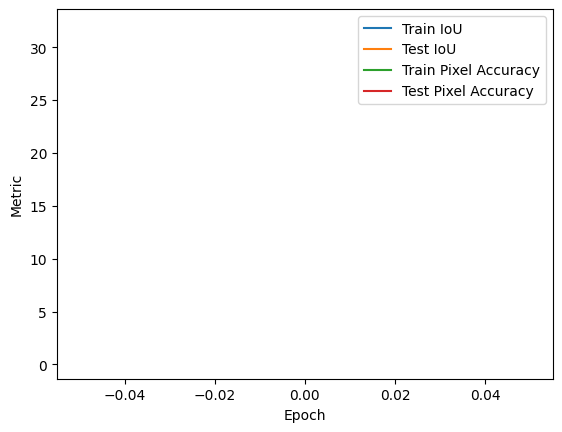

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Padding function to ensure image dimensions are divisible by 32
def pad_image(image, target_size):
    h, w = image.shape[-2:]
    new_h = (h // target_size + 1) * target_size if h % target_size != 0 else h
    new_w = (w // target_size + 1) * target_size if w % target_size != 0 else w
    pad_h = new_h - h
    pad_w = new_w - w
    image = F.pad(image, (0, pad_w, 0, pad_h))
    return image

num_epochs = 1
learning_rate= 0.1

# Define the dice loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = F.softmax(output, dim=1)
        target = F.one_hot(target, num_classes=output.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = 2.0 * (intersection + self.eps) / (union + self.eps)
        return 1.0 - dice.mean()

# Define the cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store the training loss, test loss, and evaluation metrics
train_loss_history = []
test_loss_history = []
train_iou_history = []
test_iou_history = []
train_pixel_accuracy_history = []
test_pixel_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_pixel_accuracy = 0.0

    # Training iteration
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        # Padding images
        images = pad_image(images, 32)
        masks = pad_image(masks, 32)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)  # Access 'out' from the OrderedDict

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute evaluation metrics
        pred = torch.argmax(outputs, dim=1)
        train_iou += compute_iou(pred, masks, num_classes)
        train_pixel_accuracy += (pred == masks).float().mean()

    # Calculate average training loss and evaluation metrics
    train_loss /= len(train_dataloader)
    train_iou = train_iou.mean()  # Compute mean of train_iou tensor
    train_pixel_accuracy /= len(train_dataloader)
    train_loss_history.append(train_loss)
    train_iou_history.append(train_iou.item())
    train_pixel_accuracy_history.append(train_pixel_accuracy.item())


# Testing
model.eval()

test_iou = 0.0
test_pixel_accuracy = 0.0

with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.long()

        # Padding images
        images = pad_image(images, 32)
        masks = pad_image(masks, 32)

        # Forward pass
        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)  # Access 'out' from the OrderedDict

        # Compute evaluation metrics
        test_iou += compute_iou(pred, masks, num_classes)
        test_pixel_accuracy += (pred == masks).float().mean()

    # Calculate average evaluation metrics
    test_iou /= len(test_dataloader)
    test_pixel_accuracy /= len(test_dataloader)
    test_iou_history.append(test_iou.mean().item())  # Calculate mean of test_iou tensor
    test_pixel_accuracy_history.append(test_pixel_accuracy.item())

# Print epoch results
print(f"Epoch [{epoch+1}/{num_epochs}], "
      f"Train Loss: {train_loss:.4f}, "
      f"Train IoU: {train_iou:.4f}, "
      f"Train Pixel Accuracy: {train_pixel_accuracy:.4f}, "
      f"Test IoU: {test_iou.mean():.4f}, "  # Calculate mean of test_iou tensor
      f"Test Pixel Accuracy: {test_pixel_accuracy:.4f}")

# Plot evaluation metrics history
plt.plot(train_iou_history, label='Train IoU')
plt.plot(test_iou_history, label='Test IoU')
plt.plot(train_pixel_accuracy_history, label='Train Pixel Accuracy')
plt.plot(test_pixel_accuracy_history, label='Test Pixel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

